In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense





2025-04-21 10:25:38.725358: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745211338.736481   10121 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745211338.739881   10121 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745211338.748944   10121 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745211338.748964   10121 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745211338.748990   10121 computation_placer.cc:177] computation placer alr

In [12]:
# Define dataset paths
dir = '/Dataset/Processed Images_Fruits/'
bad_path = os.path.join(dir, 'Bad Quality_Fruits')
good_path = os.path.join(dir, 'Good Quality_Fruits')
mixed_path = os.path.join(dir, 'Mixed Qualit_Fruits')

In [21]:
import os
import matplotlib.pyplot as plt

# Relative path to the dataset
dir = 'Dataset/Processed Images_Fruits/'
bad_path = os.path.join(dir, 'Bad Quality_Fruits')
good_path = os.path.join(dir, 'Good Quality_Fruits')
mixed_path = os.path.join(dir, 'Mixed Qualit_Fruits')

# Verify if directories exist
print("Bad Quality Path Exists:", os.path.exists(bad_path))
print("Good Quality Path Exists:", os.path.exists(good_path))
print("Mixed Qualit Path Exists:", os.path.exists(mixed_path))

# Load image file paths and labels
filepaths, labels = [], []
ht, wt, samples = 0, 0, 0
sample_count = 20

for quality_path in [bad_path, good_path, mixed_path]:
    if os.path.exists(quality_path):  # Ensure the path exists
        fruit_list = os.listdir(quality_path)
        for fruit in fruit_list:
            fruit_path = os.path.join(quality_path, fruit)
            img_list = os.listdir(fruit_path)
            for i, img in enumerate(img_list):
                img_path = os.path.join(fruit_path, img)
                if i < sample_count:
                    img = plt.imread(img_path)
                    ht += img.shape[0]
                    wt += img.shape[1]
                    samples += 1
                filepaths.append(img_path)
                labels.append(fruit + ('_mixed' if quality_path == mixed_path else ''))
    else:
        print(f"Path not found: {quality_path}")


Bad Quality Path Exists: True
Good Quality Path Exists: True
Mixed Qualit Path Exists: True


In [22]:
print("Current working directory:", os.getcwd())


Current working directory: /run/media/csr/New Volume/Python/Computer Vision/Project


In [23]:

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})


train_df, dummy_df = train_test_split(df, train_size=0.9, shuffle=True, random_state=123, stratify=df['labels'])
test_df, valid_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])


print(f'Train size: {len(train_df)}, Validation size: {len(valid_df)}, Test size: {len(test_df)}')
classes = train_df['labels'].unique()
print(f'Classes: {classes}')


Train size: 17573, Validation size: 977, Test size: 976
Classes: ['Lime_Bad' 'Guava_Bad' 'Pomegranate_Good' 'Lime_Good' 'Apple_Bad'
 'Orange_Bad' 'Guava_Good' 'Apple_Good' 'Orange_Good' 'Banana_mixed'
 'Banana_Good' 'Banana_Bad' 'Pomegranate_Bad' 'Guava_mixed' 'Lemon_mixed'
 'Pomegranate_mixed' 'Apple_mixed' 'Orange_mixed']


In [24]:

train_datagen = ImageDataGenerator(rescale=1.0/255, rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True)
valid_test_datagen = ImageDataGenerator(rescale=1.0/255)


train_generator = train_datagen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                                    target_size=(150, 150), batch_size=32, class_mode='categorical')
valid_generator = valid_test_datagen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                                         target_size=(150, 150), batch_size=32, class_mode='categorical')
test_generator = valid_test_datagen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                                        target_size=(150, 150), batch_size=32, class_mode='categorical')


Found 17573 validated image filenames belonging to 18 classes.
Found 977 validated image filenames belonging to 18 classes.
Found 976 validated image filenames belonging to 18 classes.


In [25]:

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(classes), activation='softmax')  
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/home/csr/ML_env/lib64/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745211631.461713   10121 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4146 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [26]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=40
)


test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test Accuracy: {test_acc:.4f}')


/home/csr/ML_env/lib64/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40


I0000 00:00:1745211635.716474   10840 service.cc:152] XLA service 0x7f46fc00b600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745211635.716489   10840 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-04-21 10:30:35.737687: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745211635.863970   10840 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/549 ━━━━━━━━━━━━━━━━━━━━ 37:19 4s/step - accuracy: 0.0312 - loss: 2.8851

I0000 00:00:1745211639.054280   10840 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


549/549 ━━━━━━━━━━━━━━━━━━━━ 128s 226ms/step - accuracy: 0.4803 - loss: 1.7648 - val_accuracy: 0.8010 - val_loss: 0.6240
Epoch 2/40
  1/549 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.6562 - loss: 0.6626

/home/csr/ML_env/lib64/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


549/549 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6562 - loss: 0.6626 - val_accuracy: 0.8031 - val_loss: 0.6361
Epoch 3/40
549/549 ━━━━━━━━━━━━━━━━━━━━ 111s 202ms/step - accuracy: 0.7669 - loss: 0.7016 - val_accuracy: 0.8260 - val_loss: 0.5354
Epoch 4/40
549/549 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7500 - loss: 0.6109 - val_accuracy: 0.8385 - val_loss: 0.5175
Epoch 5/40
549/549 ━━━━━━━━━━━━━━━━━━━━ 108s 197ms/step - accuracy: 0.8150 - loss: 0.5613 - val_accuracy: 0.8302 - val_loss: 0.5359
Epoch 6/40
549/549 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8438 - loss: 0.4691 - val_accuracy: 0.8292 - val_loss: 0.5547
Epoch 7/40
549/549 ━━━━━━━━━━━━━━━━━━━━ 107s 194ms/step - accuracy: 0.8415 - loss: 0.4563 - val_accuracy: 0.8813 - val_loss: 0.3667
Epoch 8/40
549/549 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9375 - loss: 0.1959 - val_accuracy: 0.8729 - val_loss: 0.3770
Epoch 9/40
549/549 ━━━━━━━━━━━━━━━━━━━━ 106s 193ms/step - accuracy: 0.8646 - loss: 0.4068 - val_accurac

KeyboardInterrupt: 

In [6]:
import numpy as np
import cv2
import tensorflow as tf
#from tkinter import Tk
#from tkinter.filedialog import askopenfilename
 # Save the entire model to a file
#model.save("fruit_quality_model4.h5")
 # Load the saved model
model = tf.keras.models.load_model("fruit_quality_model4.h5")

2025-04-22 14:21:50.830041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745311910.896328    6708 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745311910.911148    6708 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745311911.036858    6708 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745311911.036877    6708 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745311911.036878    6708 computation_placer.cc:177] computation placer alr

In [7]:
image_path="Dataset/Processed Images_Fruits/Good Quality_Fruits/Banana_Good/IMG_0115.JPG"

In [8]:
import tensorflow as tf
import numpy as np

def preprocess_image(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(150, 150))  
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image / 255.0  
    image = np.expand_dims(image, axis=0)  
    return image

def predict(image_path):
    
    model = tf.keras.models.load_model("fruit_quality_model4.h5")

    
    preprocessed_image = preprocess_image(image_path)

   
    prediction = model.predict(preprocessed_image)
    predicted_class = np.argmax(prediction)  

   
    class_names = {
        0: 'Apple_Bad', 1: 'Apple_Good', 2: 'Apple_mixed',
        3: 'Banana_Bad', 4: 'Banana_Good', 5: 'Banana_mixed',
        6: 'Guava_Bad', 7: 'Guava_Good', 8: 'Guava_mixed',
        9: 'Lemon_mixed', 10: 'Lime_Bad', 11: 'Lime_Good',
        12: 'Orange_Bad', 13: 'Orange_Good', 14: 'Orange_mixed',
        15: 'Pomegranate_Bad', 16: 'Pomegranate_Good', 17: 'Pomegranate_mixed'
    }

    return class_names.get(predicted_class, "Unknown")


In [9]:
import matplotlib.pyplot as plt

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Predicted class: Guava_mixed


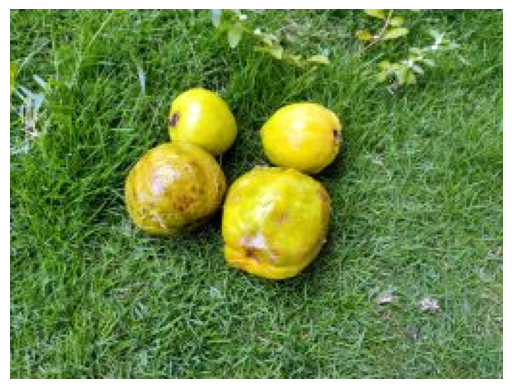

In [11]:
import cv2
import matplotlib.pyplot as plt


test_image = 'Dataset/Processed Images_Fruits/Mixed Qualit_Fruits/Guava/IMG20200728131718.jpg'


result = predict(test_image)
print(f"Predicted class: {result}")


image = cv2.imread(test_image)  


image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


plt.imshow(image_rgb)
plt.axis('off')  
plt.show()
